# Final Project, STAT-S610 - Statistical computing
### Fault Kinematics Along the San Andreas Fault from GPS Data Using Bayesian Inference and MCMC
Nicolás Castro-Perdomo

### Main Goal: 
- Using Bayesian inference and random walk Metropolis (RWM) Markov Chain Monte Carlo (MCMC) sampling to estimate four fault kinematic parameters $(a, v_0, D_L, x_0)$ in an elastic dislocation model (e.g., Weertman and Weertman, 1964; Savage and Burford, 1973). 

- This model describes the theoretical horizontal velocity profile across a vertical fault as a function of the distance $x$ from the fault:

$$
\begin{align}
v(x) = a + \frac{v_0}{\pi} tan^{-1} \Big( \frac{x-x_0}{D_L} \Big)
\end{align}
$$

where $a$ is a constant vertical shift applied to the velocity profile, $v_0$ is the fault slip rate, $D_L$ is the fault locking depth, $x_0$ is the fault location and $x$ is the distance perpendicular to the fault.

### Part 1: Model parameters

In [1]:
"""
Final Project - Statistical Computing
Slip Rate and Locking Depth Estimation Along the San Andreas Fault from GPS Data Using Bayesian Inference and MCMC
 - fault slip rate is v0 ∈ [0, 100] (mm/year)
 - locking depth is D ∈ [0, 50] (km) 
 - fault location is x0 ∈ [−10, 10] (km)
Nicolas Castro-Perdomo, November 2022
"""
#%%%%%%%%%%%%%%%%%%%%%%%% Import required modules %%%%%%%%%%%%%%%%%%%%%%%%%
%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import interactive
import seaborn as sb
import math
import time
import corner
from scipy import stats
interactive(True)
sb.set(style='white')

### Read and Plot Input Data

In [2]:
#%%%%%%%%%%%%%%%%%%%%%%%%%% Read Input Data %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
data = np.loadtxt('input_gps_california.csv',dtype=float, delimiter=',')
x_data = data[:,0]
v_data = data[:,1]
x = np.linspace(-150, 150,1000)

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%  Functions  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Elastic halfspace model (Savage & Burford, 1973)
def elastic_model(x, a, v_0, D, x_0):
    return a - v_0*np.arctan((x-x_0)/D)/np.pi

def update(a = -1, v_0 = 37, D = 20, x_0 = -2):
    line.set_ydata(elastic_model(x,a,v_0,D,x_0))
    fig.canvas.draw_idle()

<IPython.core.display.Javascript object>


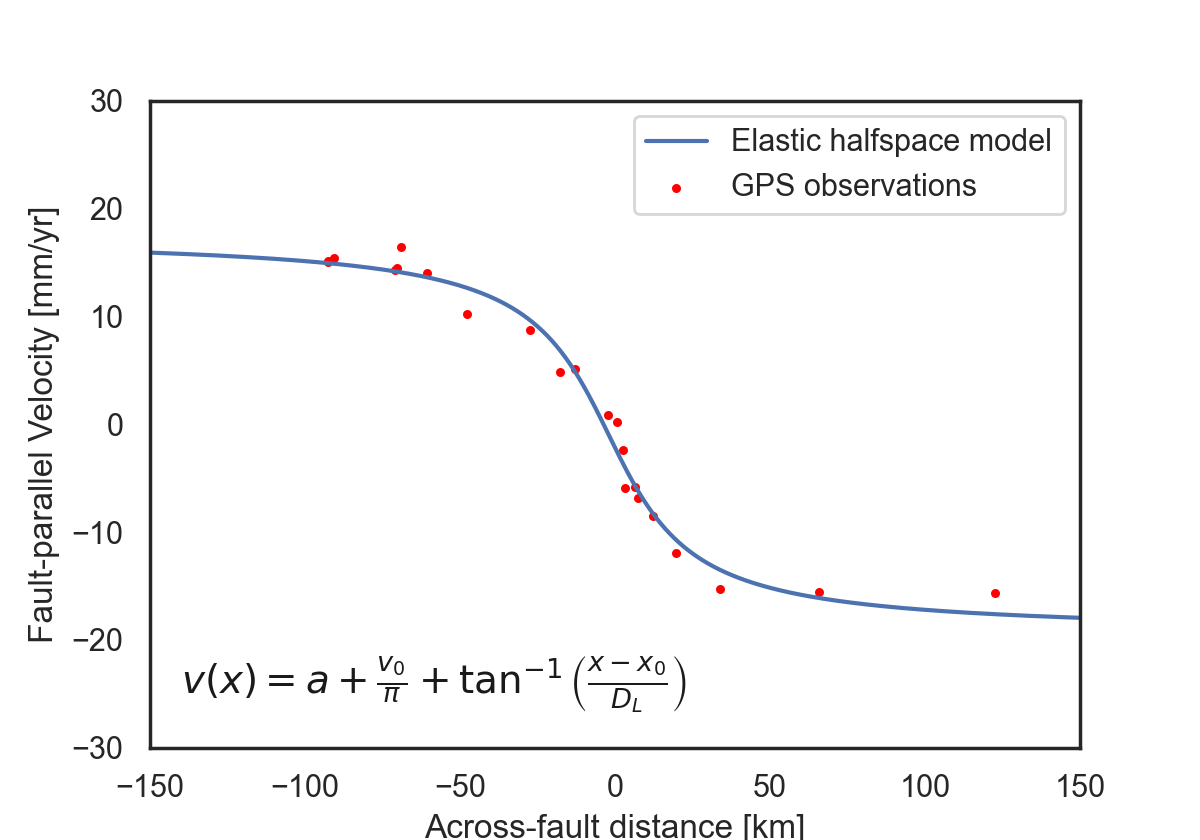

interactive(children=(FloatSlider(value=-1.0, description='a', max=5.0, min=-5.0), FloatSlider(value=37.0, des…

In [3]:
fig = plt.figure(figsize=(6, 4.2))
ax = fig.add_subplot(1, 1, 1)
line, = ax.plot(x, elastic_model(x, a = 1, v_0 = 1, D = 1, x_0 = 1), label='Elastic halfspace model')
plt.scatter(x_data, v_data, s=5, color='red', label='GPS observations')
plt.xlabel('Across-fault distance [km]') ; plt.ylabel('Fault-parallel Velocity [mm/yr]')  
plt.legend()
interact(update, a = (-5,5,0.1), v_0 = (0,50,0.1), D = (0.1,50,0.1), x_0 = (-25,25,0.1))
plt.text(-140, -25, r'$v(x) = a + \frac{v_0}{\pi} + \tan^{-1} \left( \frac{x-x_0}{D_L} \right)$', color="k", fontsize=14)
ax.set(xlim=(min(x), max(x)), ylim=(-30, 30)) ;

### Grid Search 

In [4]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%  Variables  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
pred = 0 # Declare variable pred (predicted velocity)  
diff = 0 # Declare variable dif (obsserved-predicted) ;
loc=0;  # Declare counter variable to be used when saving grid-search results
rmse=0; # Declare variable rmse  

#%%%%%%%%%%%%%%%%%%%%%%%% Define Parameter Domain %%%%%%%%%%%%%%%%%%%%%%%%%%
ai=-2.0  # Minimum arctan shift considered
af=2.0   # Maximum arctan shift considered
vi=0.0 # Minimum slip rate considered
vf=80  # Maximum slip rate considered
di=0.1 # Minimum locking depth considered
df=80  # Maximum locking depth considered
x0i=-2.5 # Minimum fault location considered
x0f=2.5  # Maximum fault location considered
stepv=0.5  # Grid search step for slip rate in mm/yr
stepd=0.5  # Grid search step for locking depth in km
stepa=0.5  # Grid search step for arctan shift in mm/yr
stepx0=0.5 # Grid search step for fault location in km

#%%%%%%%%%%%%%%%%%% Initialise table containing the results %%%%%%%%%%%%%%%%
a_vals = np.arange(ai, af + stepa, stepa, dtype = float)
v_vals = np.arange(vi, vf + stepv, stepv, dtype = float)
d_vals = np.arange(di, df + stepd, stepd, dtype = float)
x0_vals = np.arange(x0i, x0f, stepx0, dtype = float)
numiter = len(a_vals) * len(v_vals) * len(d_vals) * len(x0_vals);
table = np.zeros((numiter,5), dtype = float) # Results array, 5 columns (# params)
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [5]:
# Using meshgrid to avoid 4 nested for-loops to generate all the possible model-parameter combinations
table = np.array(np.meshgrid(a_vals, v_vals, d_vals, x0_vals, np.nan)).T.reshape(-1, 5)
a = table[:,0]  # parameter 1: Vertical shift of the arctan curve
v = table[:,1]  # parameter 2: Fault slip rate (amplitude of the arctan curve)
d = table[:,2]  # parameter 3: Fault locking depth (determines near-fault velocity gradient)
x0 = table[:,3] # parameter 4: 
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%  Functions  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
def rms(x):
    return np.sqrt(x.dot(x)/x.size)

In [6]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%% Grid Search Routine %%%%%%%%%%%%%%%%%%%%%%%%%%%
start_time = time.time()
for theta in range(len(table)):
    pred = elastic_model(x_data, a[theta], v[theta], d[theta], x0[theta])
    diff = (v_data-pred) 
    rmse = rms(diff) 
    table[loc,4]= rmse #% Save RMSE for each model 
    loc=loc+1;  #% Counter (index) to save all the results in the matrix
executionTime = (time.time() - start_time)

In [7]:
#%%%%%%%%%%%%%%%%%%%%%%%%% Extract best fit model %%%%%%%%%%%%%%%%%%%%%%%%%%
best_rms = np.min(table[:,4]) # Get minimum rmse
index_best_rms = np.where(table[:,4] == np.min(table[:,4])) # Get minimum rmse index
results = table[index_best_rms,:] # Get model parameters with the lowest rmse
results = results.flatten()
best_a = results[0] # Best fit arctangent vertical shift (a)
best_v = results[1] # Best fit fault slip rate (v)
best_d = results[2] # Best fit fault locking depth (d)
best_x0 = results[3] # Best fit fault locking depth (d)
print("Best fit model parameters:", results)
print("Grid Search Execution Time (seconds):", executionTime)

Best fit model parameters: [-1.         37.         20.1        -2.          1.37710101]
Grid Search Execution Time (seconds): 20.21146011352539


<IPython.core.display.Javascript object>


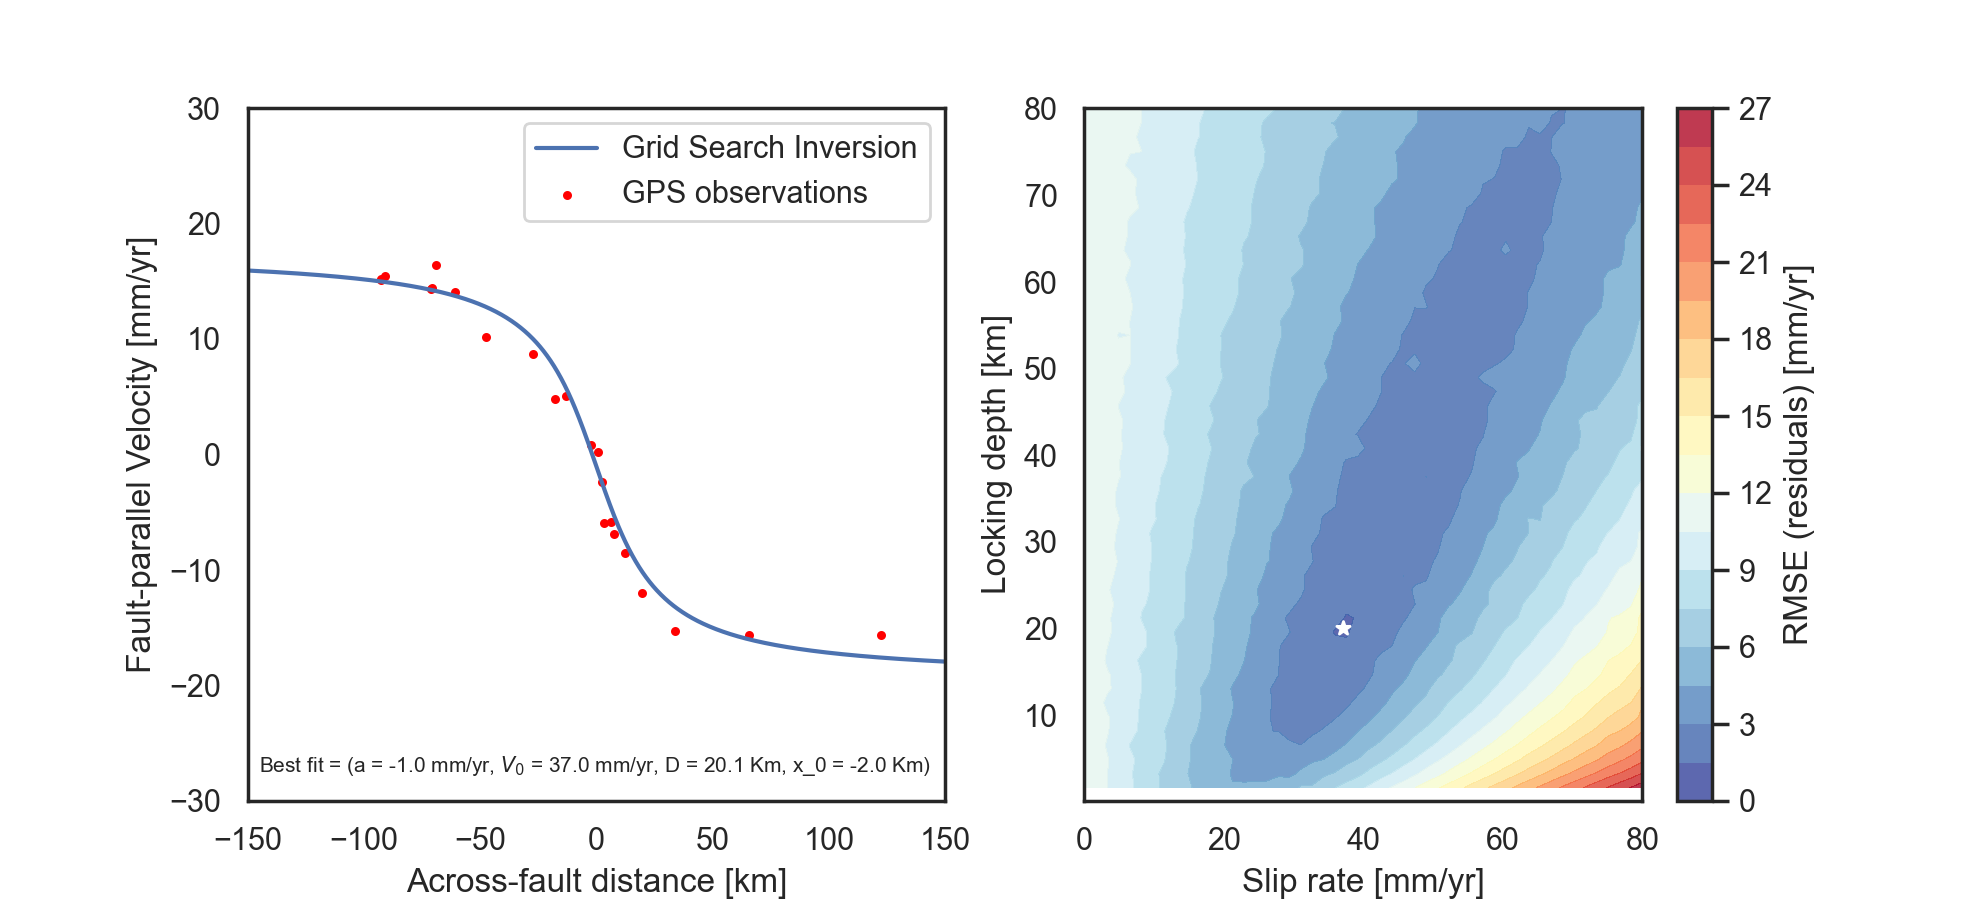

In [8]:
#%%%%%%%%%%%%%%%%%%%%%%%  Plot grid search results  %%%%%%%%%%%%%%%%%%%%%%%%%
from scipy.interpolate import griddata
from matplotlib.colors import ListedColormap
from matplotlib import cm
#%%%%%%%%%%%%%%%%%%%%%%%%%  Plotting parameters  %%%%%%%%%%%%%%%%%%%%%%%%%%%%
min_y = -30 # mm/yr
max_y = 30 # mm/yr

fig = plt.figure(figsize=(9.9,4.5))
ax1 = fig.add_subplot(1, 2, 1)
grid_search_model_predictions = elastic_model(x, best_a, best_v, best_d, 0)
ax1.plot(x, grid_search_model_predictions, label='Grid Search Inversion')
plt.scatter(x_data, v_data, s=5, color='red', label='GPS observations')
plt.xlabel('Across-fault distance [km]')
plt.ylabel('Fault-parallel Velocity [mm/yr]')
plt.legend()
offset = 5 
ax1.set(xlim=(min(x), max(x)), ylim=(min_y, max_y)) ;
disp = ax1.annotate('Best fit = (a = %.1f mm/yr, $V_0$ = %.1f mm/yr, D = %.1f Km, x_0 = %.1f Km)'%
                    (best_a, best_v, best_d, best_x0), (best_v, best_d), 
                    xytext = (min(x) + offset, min_y + 0.5*offset), fontsize=7.5)

#%%%%%%%%%%%%%%%%%%%%%%%%%%%% Define Colormap  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%
RdYlBu_r = cm.get_cmap('RdYlBu_r', 256)
newcolors = RdYlBu_r(np.linspace(0, 1, 100))
newcmp = ListedColormap(newcolors)

#%%%%%%%%%  Interpolate RMSE values into a 50x50 grid and plot %%%%%%%%%%%%%
v_vals=table[:,1]
d_vals=table[:,2]
rmse_vals=table[:,4]
xi=np.linspace(0.,80.,50)
yi=np.linspace(0.,80.,50)

X,Y= np.meshgrid(xi,yi)
Z = griddata((v_vals, d_vals), rmse_vals, (X, Y),method='linear')
ax2 = fig.add_subplot(1, 2, 2)
ax2.set(xlim=(min(v_vals), max(v_vals)), ylim=(min(d_vals), max(d_vals))) 
cs = plt.contourf(X,Y,Z,16,cmap=newcmp,alpha=0.8)
cbar = plt.colorbar(cs)
cbar.set_label('RMSE (residuals) [mm/yr]')
ax2.scatter(best_v, best_d, s=25, marker='*', color='white', zorder=2)
ax2.set_xlabel('Slip rate [mm/yr]')
ax2.set_ylabel('Locking depth [km]') ;